In [321]:
import pandas as pd

df = pd.read_csv(r'https://raw.githubusercontent.com/4GeeksAcademy/logistic-regression-project-tutorial/main/bank-marketing-campaign-data.csv', delimiter=';')
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [322]:
df.shape

(41188, 21)

In [323]:
df.rename(columns={'cons.price.idx': 'cons_price_idx'}, inplace=True)

In [324]:
df.rename(columns={'cons.conf.idx': 'cons_conf_idx'}, inplace=True)

In [325]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons_price_idx  41188 non-null  float64
 17  cons_conf_idx   41188 non-null 

In [326]:
df.nunique()
#debo revisar cual es la edad menor y la edad mayor disponible primero y establecer el rango de edad con la que es seguro trabajar, tener preferencia con la gente que tiene trabajo sea dependiente o independiente, que no tiene ningun tipo de deuda al momento o por lo menos no de housing.

age                 78
job                 12
marital              4
education            8
default              3
housing              3
loan                 3
contact              2
month               10
day_of_week          5
duration          1544
campaign            42
pdays               27
previous             8
poutcome             3
emp.var.rate        10
cons_price_idx      26
cons_conf_idx       26
euribor3m          316
nr.employed         11
y                    2
dtype: int64

In [327]:
df.drop(['marital', 'education', 'month', 'duration', 'campaign', 'previous', 'poutcome', 'nr.employed', 'pdays', 'contact', 'day_of_week', 'emp.var.rate'],axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)
df

,age,job,default,housing,loan,cons_price_idx,cons_conf_idx,euribor3m,y
0,56,housemaid,no,no,no,93.994,-36.4,4.857,no
1,57,services,unknown,no,no,93.994,-36.4,4.857,no
2,37,services,no,yes,no,93.994,-36.4,4.857,no
3,40,admin.,no,no,no,93.994,-36.4,4.857,no
4,56,services,no,no,yes,93.994,-36.4,4.857,no
...,...,...,...,...,...,...,...,...,...
41183,73,retired,no,yes,no,94.767,-50.8,1.028,yes
41184,46,blue-collar,no,no,no,94.767,-50.8,1.028,no
41185,56,retired,no,yes,no,94.767,-50.8,1.028,no
41186,44,technician,no,no,no,94.767,-50.8,1.028,yes


In [328]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,41188.0,40.024060,10.421250,17.000,32.000,38.000,47.000,98.000
cons_price_idx,41188.0,93.575664,0.578840,92.201,93.075,93.749,93.994,94.767
cons_conf_idx,41188.0,-40.502600,4.628198,-50.800,-42.700,-41.800,-36.400,-26.900
euribor3m,41188.0,3.621291,1.734447,0.634,1.344,4.857,4.961,5.045


In [329]:
df.isnull().mean()*100 #mi dataset no tiene datos Nan

age               0.0
job               0.0
default           0.0
housing           0.0
loan              0.0
cons_price_idx    0.0
cons_conf_idx     0.0
euribor3m         0.0
y                 0.0
dtype: float64

In [330]:
df.isna().sum()

age               0
job               0
default           0
housing           0
loan              0
cons_price_idx    0
cons_conf_idx     0
euribor3m         0
y                 0
dtype: int64

In [331]:
#comienzo a filtrar primero por grupos de edad. Esto me indica que la edad minima es 17 y la maxima 98, el describe me indica que la medio por grupos percentiles de solo el 25% ya es de 32, y la del percentil 75 es de 47. 
#Con base en este informacion puedo delimitar el grupo de individuos cuya edad minima y maxima esten 5 unidades por encima y debajo de las medias de los cuartiles, es decir 27 y 52
age_population = df[['age']].groupby('age').value_counts()
age_population

age
17      5
18     28
19     42
20     65
21    102
     ... 
91      2
92      4
94      1
95      1
98      2
Name: count, Length: 78, dtype: int64

In [332]:
filtro_edad = df.query('age >= 27 and age <=52')
filtro_edad #aqui mi base de datos se reduce pero no significativamente, ahora tengo un rango de edad mas adecuado para ofrecer un credito.

,age,job,default,housing,loan,cons_price_idx,cons_conf_idx,euribor3m,y
2,37,services,no,yes,no,93.994,-36.4,4.857,no
3,40,admin.,no,no,no,93.994,-36.4,4.857,no
5,45,services,unknown,no,no,93.994,-36.4,4.857,no
7,41,blue-collar,unknown,no,no,93.994,-36.4,4.857,no
10,41,blue-collar,unknown,no,no,93.994,-36.4,4.857,no
...,...,...,...,...,...,...,...,...,...
41180,36,admin.,no,no,no,94.767,-50.8,1.028,no
41181,37,admin.,no,yes,no,94.767,-50.8,1.028,yes
41182,29,unemployed,no,yes,no,94.767,-50.8,1.028,no
41184,46,blue-collar,no,no,no,94.767,-50.8,1.028,no


In [333]:
filtro_edad[['age']].groupby('age').value_counts() #ahora tengo una base de datos con informacion de grupos de edad un tanto mas significativa

age
27     851
28    1001
29    1453
30    1714
31    1947
32    1846
33    1833
34    1745
35    1759
36    1780
37    1475
38    1407
39    1432
40    1161
41    1278
42    1142
43    1055
44    1011
45    1103
46    1030
47     928
48     979
49     839
50     875
51     754
52     779
Name: count, dtype: int64

In [334]:
filtro_edad[['job']].groupby('job').value_counts()

job
admin.           8988
blue-collar      7911
entrepreneur     1221
housemaid         756
management       2339
retired           179
self-employed    1170
services         3344
student           344
technician       5858
unemployed        847
unknown           220
Name: count, dtype: int64

In [335]:
eliminar_trabajos = ['housemaid', 'student', 'unemployed', 'unknown']
gente_con_trabajo = filtro_edad[-filtro_edad['job'].isin(eliminar_trabajos)]
gente_con_trabajo #sigo manteniendo buen nivel de datos.
#sobreentiendo que el hecho de que tenga trabajo aumenta la probabilidad de que, al recibir una nueva oferta de prestamo, lo tome, despectivamente de que la variable y diga que no, pues, segun los datos completos
#del dataframe, supongo que es la respuesta a la ultima oferta, validar de nuevo puede dar un resultado positivo si las condiciones de la persona han cambiado

,age,job,default,housing,loan,cons_price_idx,cons_conf_idx,euribor3m,y
2,37,services,no,yes,no,93.994,-36.4,4.857,no
3,40,admin.,no,no,no,93.994,-36.4,4.857,no
5,45,services,unknown,no,no,93.994,-36.4,4.857,no
7,41,blue-collar,unknown,no,no,93.994,-36.4,4.857,no
10,41,blue-collar,unknown,no,no,93.994,-36.4,4.857,no
...,...,...,...,...,...,...,...,...,...
41172,31,admin.,no,yes,no,94.767,-50.8,1.031,yes
41180,36,admin.,no,no,no,94.767,-50.8,1.028,no
41181,37,admin.,no,yes,no,94.767,-50.8,1.028,yes
41184,46,blue-collar,no,no,no,94.767,-50.8,1.028,no


In [336]:
gente_con_trabajo[['job']].groupby('job').value_counts()#vuelvo a revisar para ver si los trabajos se eliminaron correctamente

job
admin.           8988
blue-collar      7911
entrepreneur     1221
management       2339
retired           179
self-employed    1170
services         3344
technician       5858
Name: count, dtype: int64

In [337]:
unknown_default_cantidad = gente_con_trabajo[['default']].groupby('default').value_counts()
unknown_default_cantidad
#para continuar necesito convertir todos los valores de los tipos de credito a binario 0 para si 1 para no, por tanto los datos unknown me estorban. Comienzo por la variable del credito default

default
no         24872
unknown     6136
yes            2
Name: count, dtype: int64

In [338]:
eliminar_unknown = ['unknown']
gente_con_default = gente_con_trabajo[-gente_con_trabajo['default'].isin(eliminar_unknown)]
gente_con_default

,age,job,default,housing,loan,cons_price_idx,cons_conf_idx,euribor3m,y
2,37,services,no,yes,no,93.994,-36.4,4.857,no
3,40,admin.,no,no,no,93.994,-36.4,4.857,no
12,29,blue-collar,no,no,yes,93.994,-36.4,4.857,no
14,35,blue-collar,no,yes,no,93.994,-36.4,4.857,no
16,35,blue-collar,no,yes,no,93.994,-36.4,4.857,no
...,...,...,...,...,...,...,...,...,...
41172,31,admin.,no,yes,no,94.767,-50.8,1.031,yes
41180,36,admin.,no,no,no,94.767,-50.8,1.028,no
41181,37,admin.,no,yes,no,94.767,-50.8,1.028,yes
41184,46,blue-collar,no,no,no,94.767,-50.8,1.028,no


In [339]:
#Ahora reviso la variable housing
unknown_housing_cantidad = gente_con_trabajo[['housing']].groupby('housing').value_counts()
unknown_housing_cantidad #sigo teniendo datos inservibles por este lado, debo eliminarlos

housing
no         14071
unknown      743
yes        16196
Name: count, dtype: int64

In [340]:
eliminar_unknown = ['unknown']
gente_con_housing = gente_con_default[-gente_con_default['housing'].isin(eliminar_unknown)]
gente_con_housing

,age,job,default,housing,loan,cons_price_idx,cons_conf_idx,euribor3m,y
2,37,services,no,yes,no,93.994,-36.4,4.857,no
3,40,admin.,no,no,no,93.994,-36.4,4.857,no
12,29,blue-collar,no,no,yes,93.994,-36.4,4.857,no
14,35,blue-collar,no,yes,no,93.994,-36.4,4.857,no
16,35,blue-collar,no,yes,no,93.994,-36.4,4.857,no
...,...,...,...,...,...,...,...,...,...
41172,31,admin.,no,yes,no,94.767,-50.8,1.031,yes
41180,36,admin.,no,no,no,94.767,-50.8,1.028,no
41181,37,admin.,no,yes,no,94.767,-50.8,1.028,yes
41184,46,blue-collar,no,no,no,94.767,-50.8,1.028,no


In [341]:
#ahora reviso los de loan
unknown_housing_loan = gente_con_housing[['loan']].groupby('loan').value_counts()
unknown_housing_loan #aqui ya no tengo unknown, pero si los tengo en la variable job

loan
no     20465
yes     3821
Name: count, dtype: int64

In [342]:
gente_con_housing[['job']].groupby('job').value_counts()

job
admin.           7764
blue-collar      5130
entrepreneur      950
management       1947
retired           110
self-employed     912
services         2495
technician       4978
Name: count, dtype: int64

In [343]:
binary_jobs = gente_con_housing

def get_binary_jobs(row):
    is_job = row['job']
    if is_job == 'admin.':
        return 0
    elif is_job == 'blue-collar':
        return 1
    elif is_job == 'entrepreneur':
        return 2
    elif is_job == 'management':
        return 3
    elif is_job == 'retired':
        return 4
    elif is_job == 'self-employed':
        return 5
    elif is_job == 'services':
        return 6
    elif is_job == 'technician':
        return 7
    
binary_jobs['job'] = binary_jobs.apply(get_binary_jobs, axis=1)
binary_jobs

/tmp/ipykernel_18984/701858743.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  binary_jobs['job'] = binary_jobs.apply(get_binary_jobs, axis=1)


,age,job,default,housing,loan,cons_price_idx,cons_conf_idx,euribor3m,y
2,37,6,no,yes,no,93.994,-36.4,4.857,no
3,40,0,no,no,no,93.994,-36.4,4.857,no
12,29,1,no,no,yes,93.994,-36.4,4.857,no
14,35,1,no,yes,no,93.994,-36.4,4.857,no
16,35,1,no,yes,no,93.994,-36.4,4.857,no
...,...,...,...,...,...,...,...,...,...
41172,31,0,no,yes,no,94.767,-50.8,1.031,yes
41180,36,0,no,no,no,94.767,-50.8,1.028,no
41181,37,0,no,yes,no,94.767,-50.8,1.028,yes
41184,46,1,no,no,no,94.767,-50.8,1.028,no


In [344]:
#ahora procedo a reemplazar los valores yes o no por 0 y 1
gente_con_default = binary_jobs
def get_default(row):
    is_default = row['default']
    if is_default == 'yes':
        return 0
    elif is_default == 'no':
        return 1
    
gente_con_default['default'] = gente_con_default.apply(get_default, axis=1)
gente_con_default

/tmp/ipykernel_18984/2509369134.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gente_con_default['default'] = gente_con_default.apply(get_default, axis=1)


,age,job,default,housing,loan,cons_price_idx,cons_conf_idx,euribor3m,y
2,37,6,1,yes,no,93.994,-36.4,4.857,no
3,40,0,1,no,no,93.994,-36.4,4.857,no
12,29,1,1,no,yes,93.994,-36.4,4.857,no
14,35,1,1,yes,no,93.994,-36.4,4.857,no
16,35,1,1,yes,no,93.994,-36.4,4.857,no
...,...,...,...,...,...,...,...,...,...
41172,31,0,1,yes,no,94.767,-50.8,1.031,yes
41180,36,0,1,no,no,94.767,-50.8,1.028,no
41181,37,0,1,yes,no,94.767,-50.8,1.028,yes
41184,46,1,1,no,no,94.767,-50.8,1.028,no


In [345]:
binary_housing = gente_con_default

def get_housing(row):
    is_housing = row['housing']
    if is_housing == 'yes':
        return 0
    elif is_housing == 'no':
        return 1
    
binary_housing['housing'] = binary_housing.apply(get_housing, axis=1)
binary_housing

/tmp/ipykernel_18984/3692811556.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  binary_housing['housing'] = binary_housing.apply(get_housing, axis=1)


,age,job,default,housing,loan,cons_price_idx,cons_conf_idx,euribor3m,y
2,37,6,1,0,no,93.994,-36.4,4.857,no
3,40,0,1,1,no,93.994,-36.4,4.857,no
12,29,1,1,1,yes,93.994,-36.4,4.857,no
14,35,1,1,0,no,93.994,-36.4,4.857,no
16,35,1,1,0,no,93.994,-36.4,4.857,no
...,...,...,...,...,...,...,...,...,...
41172,31,0,1,0,no,94.767,-50.8,1.031,yes
41180,36,0,1,1,no,94.767,-50.8,1.028,no
41181,37,0,1,0,no,94.767,-50.8,1.028,yes
41184,46,1,1,1,no,94.767,-50.8,1.028,no


In [346]:
binary_loan = binary_housing

def get_loan(row):
    is_loan = row['loan']
    if is_loan == 'yes':
        return 0
    elif is_loan == 'no':
        return 1
    
binary_loan['loan'] = binary_loan.apply(get_loan, axis=1)
binary_loan

/tmp/ipykernel_18984/2947608282.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  binary_loan['loan'] = binary_loan.apply(get_loan, axis=1)


,age,job,default,housing,loan,cons_price_idx,cons_conf_idx,euribor3m,y
2,37,6,1,0,1,93.994,-36.4,4.857,no
3,40,0,1,1,1,93.994,-36.4,4.857,no
12,29,1,1,1,0,93.994,-36.4,4.857,no
14,35,1,1,0,1,93.994,-36.4,4.857,no
16,35,1,1,0,1,93.994,-36.4,4.857,no
...,...,...,...,...,...,...,...,...,...
41172,31,0,1,0,1,94.767,-50.8,1.031,yes
41180,36,0,1,1,1,94.767,-50.8,1.028,no
41181,37,0,1,0,1,94.767,-50.8,1.028,yes
41184,46,1,1,1,1,94.767,-50.8,1.028,no


In [347]:
binary_target = binary_loan

def get_target(row):
    is_target = row['y']
    if is_target == 'yes':
        return 0
    elif is_target == 'no':
        return 1
    
binary_target['y'] = binary_target.apply(get_target, axis=1)
binary_target

/tmp/ipykernel_18984/2443343162.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  binary_target['y'] = binary_target.apply(get_target, axis=1)


,age,job,default,housing,loan,cons_price_idx,cons_conf_idx,euribor3m,y
2,37,6,1,0,1,93.994,-36.4,4.857,1
3,40,0,1,1,1,93.994,-36.4,4.857,1
12,29,1,1,1,0,93.994,-36.4,4.857,1
14,35,1,1,0,1,93.994,-36.4,4.857,1
16,35,1,1,0,1,93.994,-36.4,4.857,1
...,...,...,...,...,...,...,...,...,...
41172,31,0,1,0,1,94.767,-50.8,1.031,0
41180,36,0,1,1,1,94.767,-50.8,1.028,1
41181,37,0,1,0,1,94.767,-50.8,1.028,0
41184,46,1,1,1,1,94.767,-50.8,1.028,1


In [348]:
filtered_df = binary_target
sesgo = filtered_df.apply(lambda x: x.skew())
sesgo #hay un sesgo extremadamente negativo en default, lo cual no es normal, ya que el sesgo comun es de -2 a 2, debo revisar esa columna para establecer el porque de estos datos

age                 0.483263
job                 0.479598
default          -110.188474
housing             0.155131
loan               -1.882306
cons_price_idx     -0.071570
cons_conf_idx       0.316998
euribor3m          -0.649229
y                  -2.517090
dtype: float64

In [349]:
filtered_df[['default']].groupby('default').value_counts() #esto me muestra la razon del sesgo negativo extremadamente alto y es por que hay una distribucion de datos desequilibrada, pero esto no significa un problema para continuar con el eda.

default
0        2
1    24284
Name: count, dtype: int64

In [360]:
import statsmodels.api as sm
# Variables independientes/dependiente
X = filtered_df.drop(['default', 'housing', 'loan', 'cons_conf_idx'], axis=1)
y = filtered_df['cons_conf_idx']

# Ajusta el modelo
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

# Instancia de la influencia y obtención de la distancia de cook para cada observación
cooks_distance = model.get_influence().cooks_distance

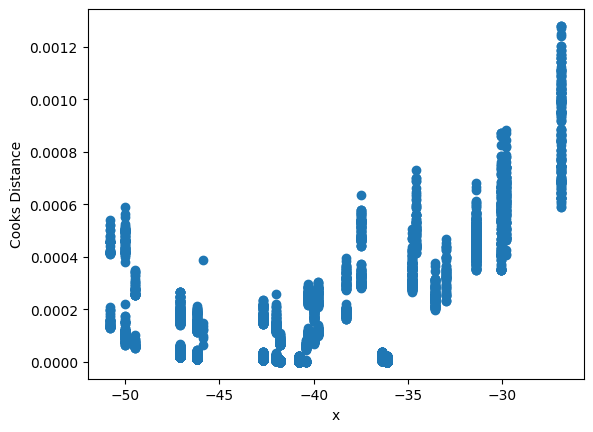

In [361]:
import matplotlib.pyplot as plt

plt.scatter(filtered_df.cons_conf_idx, cooks_distance[0])
plt.xlabel('x')
plt.ylabel('Cooks Distance')
plt.show()

In [362]:
filtered_df[['cons_conf_idx']].groupby('cons_conf_idx').value_counts() #esto me muestra que la mayoria de las personas disponibles tienen un indice de confianza bajo, pero debido a que la investigacion va de que sujetos son mas propensos a aceptar un credito
#todavia esto no especifica que no lo vayan  a aceptar, como dije antes, todavia esta la variable de si tienen creditos y de que tipo y condiciones de pago, bien su indice de confianza podria deberse a problemas para pagar las cuotas de alguno de ellos.

cons_conf_idx
-50.8      82
-50.0     174
-49.5      87
-47.1    1538
-46.2    3923
-45.9       8
-42.7    3655
-42.0    2605
-41.8    2303
-40.8     426
-40.4      53
-40.3     156
-40.0     109
-39.8     146
-38.3     122
-37.5     160
-36.4    4203
-36.1    3250
-34.8     144
-34.6      80
-33.6     105
-33.0      60
-31.4     374
-30.1     180
-29.8     125
-26.9     218
Name: count, dtype: int64

In [ ]:
.query

In [ ]:
#al principio queria filtrar fuera las personas que tenian creditos de housing, pero como no se que tipo de condiciones tiene el credito que el banco esta queriendo ofrecer, a lo mejor, si las condiciones son mejores que las del credito
#hipotecario, podria ser un factor que haga a la gente aceptar el credito, entonces dejo esa variable intacta.

corr = filtered_df.corr()
corr.style.background_gradient(cmap='coolwarm').format(precision=3)

,age,job,default,housing,loan,cons.price.idx,cons.conf.idx,euribor3m,y
age,1.000,-0.010,-0.014,0.001,0.008,0.032,0.053,0.067,0.025
job,-0.010,1.000,-0.013,-0.006,0.016,0.008,0.025,0.048,0.012
default,-0.014,-0.013,1.000,-0.001,-0.004,0.002,-0.009,-0.007,-0.003
housing,0.001,-0.006,-0.001,1.000,0.053,0.087,0.033,0.060,0.010
loan,0.008,0.016,-0.004,0.053,1.000,0.008,0.020,0.006,-0.007
cons.price.idx,0.032,0.008,0.002,0.087,0.008,1.000,0.140,0.689,0.115
cons.conf.idx,0.053,0.025,-0.009,0.033,0.020,0.140,1.000,0.360,-0.041
euribor3m,0.067,0.048,-0.007,0.060,0.006,0.689,0.360,1.000,0.274
y,0.025,0.012,-0.003,0.010,-0.007,0.115,-0.041,0.274,1.000
